# When Gurobi is Not Enough

*Combinatorial Optimization course, FEE CTU in Prague. Created by [Industrial Informatics Department](https://iid.ciirc.cvut.cz/).*

In the previous weeks, we used ILP to model and solve various problems, and we presented the performance of the Gurobi solver. Therefore, the question is, why should you ever use anything but modern ILP solvers?

### 1.   Problem Formulation
ILP formalism requires both the objective function and the constraints to be linear functions of the variables. This can be quite restrictive:

$$
\begin{align*}
\textrm{minimize} && \mathbf{x}^T\mathbf{C}\mathbf{x} + \mathbf{c}^T\mathbf{x} + e^{\mathbf{d}^T\mathbf{x}} \\
\textrm{subject to} && \mathbf{A}\mathbf{x} \le \mathbf{b} \\
&& \mathbf{l} \le \mathbf{x} \le \mathbf{u} \\
&& \mathbf{x} \in \mathbb{Z}^n
\end{align*}
$$

Modeling this optimization task using ILP would be rather difficult. While there are more general approaches like MIQP, MINLP or MISOCP (see more about various classes of mathematical optimization [here](https://www.gams.com/latest/docs/UG_ModelSolve.html#UG_ModelSolve_ModelClassificationOfModels
)), formulating the problem without concessions may remain problematic.

### 2. Lack of Solvers
Even when we successfully formulate the problem using ILP, we still need a tool to solve it. Gurobi provides academic licenses, so we can exploit its state-of-the-art performance without any repercussions. However, a commercial Gurobi license is quite costly, and companies may avoid its acquisition when the immediate return is unclear or expected to be marginal. Then, we could use a free alternative:

* [GLPK](https://www.gnu.org/software/glpk/)
* [lpsolve](https://lpsolve.sourceforge.net/5.5/)
* [CBC](https://github.com/coin-or/Cbc)
* [HiGHS](https://github.com/ERGO-Code/HiGHS)

While the alternatives use essentially the same techniques applied in the Gurobi solver, their performance is often insufficient, as is demonstrated in the following [benchmarks](http://plato.asu.edu/ftp/milp.html):


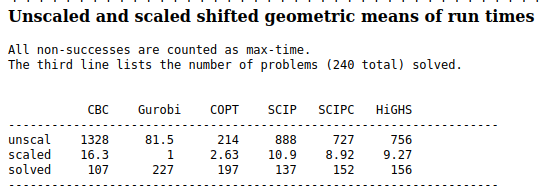

###  3. Size of the Problem
Even when we can formulate the problem using ILP and have a powerful solver ready, there are still performance issues. Industrial problems are often large (e.g., thousands of tasks in a scheduling case), and to model them, a large number of variables and constraints are needed. With the growing complexity of the problem instance, the solver would require a large amount of time to find a solution of sufficient quality or even to build a model in the first place. In an extreme case, the model will not even fit into memory.

We will demonstrate it on an instance of the *Travelling Salesman problem*. The same problem will be used later in the tutorial. Start by defining the following functions:

In [1]:
# define functions for TSP
import random # Import modules
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt

!pip install pymoo
import pymoo

# generate random TSP instance
def generate_problem(nm_cities):
    return [(random.random(), random.random()) for city in range(nm_cities)]

# calculate euclidean distance between cities
def calculate_distance(c1, c2):
    return math.sqrt((c1[0] - c2[0]) ** 2 + (c1[1] - c2[1]) ** 2)

# evaluate solution represented by permuation
def evaluate_solution(cities, permutation):
    cost = 0
    for i in range(len(cities)):
        c1, c2 = cities[permutation[i]], cities[permutation[(i+1) % len(cities)]]
        cost += calculate_distance(c1, c2)
    return cost

# plot the solution
def plot_solution(cities, permutation, ax=None, title=""):
    other_axis = ax is not None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()

    for i in range(len(cities)):
        c1, c2 = cities[permutation[i]], cities[permutation[(i+1) % len(cities)]]
        ax.plot([c1[0], c2[0]], [c1[1], c2[1]], c="blue")
    ax.scatter([c[0] for c in cities], [c[1] for c in cities], c="red", zorder=1e6)
    if len(cities) > 0:
        ax.scatter([cities[0][0]], [cities[0][1]], c="green", zorder=1e6)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    if not other_axis:
        plt.show()

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
      --------------------------------------- 0.0/1.3 MB 262.6 kB/s eta 0:00:05
     - -------------------------------------- 0.1/1.3 MB 409.6 kB/s eta 0:00:03
     -------- ------------------------------- 0.3/1.3 MB 1.6 MB/s eta 0:00:01
     ------------------------- -------------- 0.8/1.3 MB 3.6 MB/s eta 0:00:01
     ------------------------------------- -- 1.2/1.3 MB 4.4 MB/s eta 0:00:01
     ---------------------------------------- 1.3/1.3 MB 4.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with 

Import *gurobipy* and try to solve the TSP using Gurobi. The formulation corresponds to the one presented in the lecture; we do not use Lazy Constraints here.

In [2]:
!pip install gurobipy
import gurobipy as g

Defaulting to user installation because normal site-packages is not writeable


In [5]:
random.seed(5)
n = 10
# n = 2_000  # This will not work for academic licence of Gurobi here in Colab

random.seed(0)
cities = generate_problem(n)


m = g.Model()
edge_vars = m.addVars(n, n, vtype=g.GRB.BINARY, name="edge")
s_vars = m.addVars(n, vtype=g.GRB.CONTINUOUS, name="s")

m.addConstrs((edge_vars[i,i] == 0 for i in range(n)), name="diag")
m.addConstrs((edge_vars.sum(i, "*") == 1 for i in range(n)), name="out")
m.addConstrs((edge_vars.sum("*", i) == 1 for i in range(n)), name="in")
m.addConstrs((s_vars[i] + 1 <= s_vars[j] + n * (1 - edge_vars[i,j]) for i in range(n) for j in range(1, n)), name="c")

m.setObjective(g.quicksum(calculate_distance(cities[i], cities[j]) * edge_vars[i,j] for i in range(n) for j in range(n)), sense=g.GRB.MINIMIZE)
m.optimize()

solution = [0]
while len(solution) < n:
    current = solution[-1]
    for i in range(n):
        if round(edge_vars[current, i].x) > 0.5:
            solution.append(i)
            break

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120 rows, 110 columns and 462 nonzeros
Model fingerprint: 0xcd6209ff
Variable types: 10 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [1e-01, 9e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 4.2392576
Presolve removed 28 rows and 11 columns
Presolve time: 0.00s
Presolved: 92 rows, 99 columns, 396 nonzeros
Variable types: 9 continuous, 90 integer (90 binary)

Root relaxation: objective 2.040008e+00, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/

For ten cities, we find the optimum easily. However, if we would increase the size to 2000, it will take minutes to just build a model, and eventually, the process will be killed. While a TSP instance needs to be quite large to make the Gurobi solver inapplicable, there are other problems (packing, scheduling, ...) where quite small instances are enough for Gurobi to not find any solution in a reasonable time.

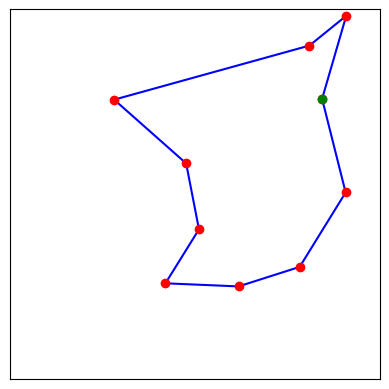

In [6]:
plot_solution(cities, solution)

###  4. Optimal Solution is Not Necessary

While the ILP solver guarantees that it will eventually find an optimal solution, it may require a long computation time. This can limit the deployment of the ILP model in the industry, where severe time constraints may apply. In this case, the good-enough solution found in a minute is more desirable than an optimal one found in an hour.

Due to these reasons, we often need to employ heuristic methods:

> any approach to problem-solving or self-discovery that employs a practical method that is not guaranteed to be optimal, perfect, or rational but is nevertheless sufficient for reaching an immediate, short-term goal or approximation.
>  -- [<cite>wikipedia</cite>](https://en.wikipedia.org/wiki/Heuristic)


# Heuristics and Metaheuristics #

Heuristics are methods that do not guarantee the optimality of the solution but usually work quite well and can be applied even for larger instances. We will demonstrate a few of the concepts, again using the *Travelling Salesman Problem*.

We will generate a small instance of just 50 cities so the visualization is clear. ILP solver would easily solve this. Note that this instance is a case of metric TSP; thus, approximate algorithms offer some guarantees.

We generate the instance and visualize it. City nm. 1 is a green dot. Tour defined by permutation $\left(1,2,\dots,n \right)$ is shown.


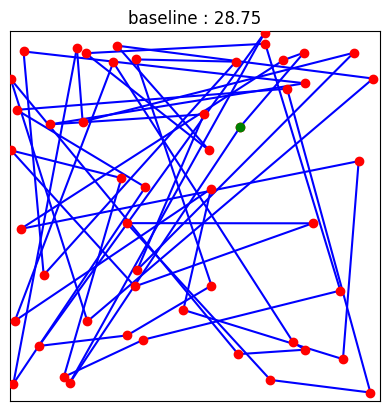

In [7]:
random.seed(5)
nm_cities = 50
cities = generate_problem(nm_cities)
solution = [i for i in range(nm_cities)]
cost = evaluate_solution(cities, solution)
plot_solution(cities, solution, None, "baseline : {:.2f}".format(cost))

number_of_evaluations = 20000   # limit on number of evaluations in following experiments

The most straightforward approach to solving this when a solver is not available would be to exhaustively check each permutation. The brute force is, however, only applicable for up to ten cities.

Solution 5040 of 5040


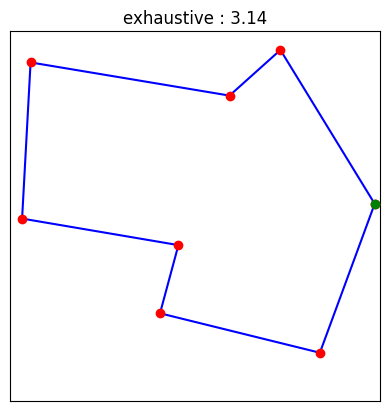

In [8]:
nm_cities = 8
cities = generate_problem(nm_cities)

assert nm_cities < 9  # Limit since otherwise it takes too long
possible_solutions = itertools.permutations(range(1, nm_cities))  # prepare all permutation

best_solution, best_cost = None, np.inf
best_costs = []

k = 0
total = math.factorial(nm_cities - 1)
for partial_solution in possible_solutions:  # check each permutation whether it improves the criterion
    solution = [0] + list(partial_solution)
    print("\rSolution {} of {}".format(k+1, total), end="")
    cost = evaluate_solution(cities, solution)
    if cost < best_cost:
      best_solution, best_cost = solution, cost
    best_costs.append(best_cost)
    k += 1
print()

best_costs_exhaustive, best_solution_exhaustive = best_costs, best_solution
plot_solution(cities, best_solution_exhaustive, None, "exhaustive : {:.2f}".format(best_cost))

Otherwise, we can search for the best solution randomly. Until we do not exceed the allowed number of evaluations, randomly sample the next permutation and evaluate the tour.

Evaluation 20000 of 20000


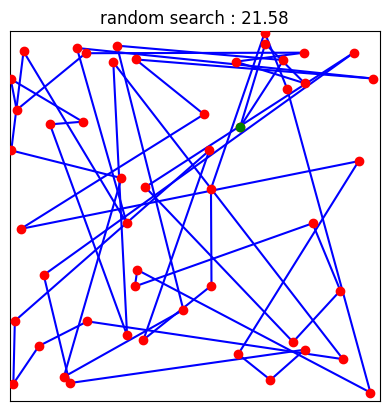

In [9]:
# Regenerating original 50 vertices problem
random.seed(5)
nm_cities = 50
cities = generate_problem(nm_cities)

np.random.seed(0)

source_permutation = np.array(list(range(nm_cities)))
def get_next_permutation():  # sample next random permutation
    new_permutation = source_permutation.copy()
    new_permutation[1:] = np.random.permutation(new_permutation[1:])
    return new_permutation

best_solution, best_cost = None, np.inf
best_costs = []

nm_iterations = number_of_evaluations
for i in range(nm_iterations):  # until there is budget, sample new permutation and evaluate it
    solution = get_next_permutation()
    print("\rEvaluation {} of {}".format(i+1, nm_iterations), end="")
    cost = evaluate_solution(cities, solution)
    if cost < best_cost:
      best_solution, best_cost = solution, cost
    best_costs.append(best_cost)
print()

best_costs_random_search, best_solution_random_search = best_costs, best_solution
best_cost_random_search = best_cost
plot_solution(cities, best_solution_random_search, None, title="random search : {:.2f}".format(best_cost_random_search))

Local search, or hill climbing, refers to a technique where we start with an initial solution. From this solution, we inspect its neighborhood and move to a promising neighbor. This is done iteratively.

If there is a single local minimum, this approach will eventually find it. Otherwise, it is sensitive to the choice of the initial solution and the definition of neighborhood.

There are many ways how to define both the neighborhood and how to select the next solution. These include first-improving (first neighbor with lower criterion) or best-improving selection (best possible neighbor). For more information regarding this, see the course [EOA](https://cw.fel.cvut.cz/wiki/courses/a0m33eoa/lectures/start), which is relevant for the entire tutorial.

In this tutorial, the neighborhood of permutation $\mathbf{s} = (s_1, s_2, \dots, s_n)$ is defined as all permutations we can obtain by switching two elements of the permutation $\mathbf{s}$. Given indices $i,j,\,i\neq j$, we get the new permutation $\mathbf{s}'$ as:
\begin{aligned}
s_i' = s_j &&\\
s_j' = s_i &&\\
s_k' = s_k && ∀ k \notin \left\{i,j\right\}
\end{aligned}

Thus, there are ${n}\choose{2}$ neigbhors of the permuation $\mathbf{s}$.

Our hill climbing algorithm is shown below. Given the initial solution and computation budget, we investigate its neighborhood. If a better solution is found, we apply it and continue hill climbing from this solution. When the computation budget is exhausted, or there is no better neighbor, end the computation.

Evaluations 5826 / 20000


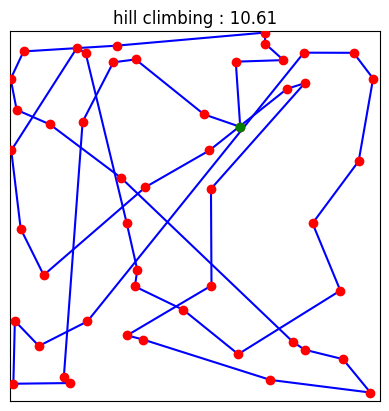

In [10]:
random.seed(0)

starting_solution = list(range(nm_cities))  # initial solution

def hill_climbing(starting_solution, cities, number_of_evaluations):
    evaluations = 0
    best_solution = starting_solution
    best_cost = evaluate_solution(cities, best_solution) # evaluate initial solution
    best_costs = [best_cost]

    combinations = list(itertools.combinations(range(0, len(cities)), 2))
    not_improved = 0  # test whether improvement happened
    combination = 0
    while evaluations < number_of_evaluations and not_improved < len(combinations):
        i1, i2 = combinations[combination]  # check specific neighbor, defined by pair
        new_solution = best_solution.copy()
        new_solution[i1], new_solution[i2] = new_solution[i2], new_solution[i1] # create neighbor

        new_cost = evaluate_solution(cities, new_solution)  # evaluate neighbor

        if new_cost < best_cost:  # if is better than current solution
            best_cost, best_solution = new_cost, new_solution  # move there
            not_improved = 0  # reset improvement counter
        else:
            not_improved += 1  # increment improvement counter


        best_costs.append(best_cost)  # memory of best solutions
        print("\rEvaluations {} / {}".format(evaluations + 1, number_of_evaluations), end="")
        evaluations += 1
        combination = (combination + 1) % len(combinations)
    print()
    return best_solution, best_cost, best_costs, evaluations

best_solution_hill_climbing, best_cost_hill_climbing, best_costs_hill_climbing, _ = hill_climbing(starting_solution, cities, number_of_evaluations)
plot_solution(cities, best_solution_hill_climbing, None, title="hill climbing : {:.2f}".format(best_cost_hill_climbing))

The solution is better than the result of a random search. However, it is still far from optimal. If we started the local search from a different solution or used an alternative neighborhood structure, we could eventually end up in the actual optimum. Often, we can use approximate algorithms (Double-Tree, Christofides) to start the search from the suitable point.

Alternatively, we employ **metaheuristics**, strategies that guide the search. There is a plethora of approaches how to guide a search, with different classifications and so on, which is demonstrated in the figure below. ([Wikipedia Metaheuristic page](https://en.wikipedia.org/wiki/Metaheuristic))

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Metaheuristics_classification.svg"  width="45%" height="45%">

More can be found in the FEE course [EOA](https://cw.fel.cvut.cz/wiki/courses/a0m33eoa/start). Just to briefly mentions two major groups, the first one modifies the hill climbing algorithm, so it can escape the local minima and continue the search. These metaheuristics include:

*   **Random-restart hill climbing** - after arriving at the local minimum, randomly sample a new starting solution and repeat the local search
*   **Simulated annealing** - given a random chance, we can move to worse neighbors to not get stuck in local minima
*   **Tabu search** - uses memory to avoid recently explored neighbors, to avoid cycling around the local minimum

The second group includes methods, which during their optimization, construct and modify a population of solutions. Rather than simply running a hill-climbing algorithm from multiple starting points, the solutions influence each other and how the new solutions are generated. These include for example:

* **Genetic algorithm** - solutions undergo mutation and cross-breed to produce the next generation with better fitness
* **Particle swarm optimization** - "flock of birds" analogy

This distinction is certainly not the only one. Also, many other metaheuristics were developed in the past, often inspired by natural phenomena (this is also true for simulated annealing or genetic algorithm). This went so far that certain journals reject papers whose sole contribution is a new nature-inspired metaheuristic (Computers & Operations Research, COR).

The more bizzare examples are mentioned [here](http://fcampelo.github.io/EC-Bestiary/), and include such algorithms as [Grey wolf optimizer](https://www.sciencedirect.com/science/article/pii/S0965997813001853?via%3Dihub), [Penguin search](https://link.springer.com/chapter/10.1007/978-3-642-38577-3_23), or [Grenade explosion method](https://www.sciencedirect.com/science/article/pii/S1568494609002543?via%3Dihub). However, there are outspoken critics of these methods regarding mostly the question of how innovative, sensible and effective these metaheuristics are and if more generic metaheuristics could achieve the same behaviour or result.

Still, applying metaheuristics to complex optimization problems is widely used, and this is documented in the COR journal. A number of papers released since 2010, which contain a specific metaheuristic in its title or keywords, is:
* Genetic algorithm - 264
* Simulated annealing - 103
* Tabu search - 179
* Variable neighborhood search - 177
* Particle swarm optimization - 49
* ...

We investigate how two of these perform on our TSP example. Starting with **random-restart hill climbing**.

Given a computation budget, we run a hill climbing from a randomly generated permutation. Until we exhaust the entire computation budget, we generate new initial permutation and run the hill climbing again.

Iteration  1
Evaluations 6362 / 20000
Iteration  2
Evaluations 6449 / 13638
Iteration  3
Evaluations 6790 / 7189
Iteration  4
Evaluations 399 / 399


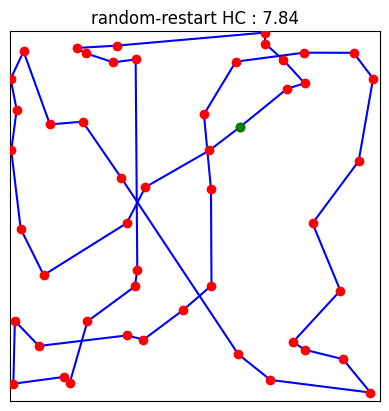

In [11]:
np.random.seed(0)

source_permutation = np.array(list(range(nm_cities)))
def get_next_permutation():  # get initial permutation for hill climbing
    new_permutation = source_permutation.copy()
    new_permutation[1:] = np.random.permutation(new_permutation[1:])
    return new_permutation

def random_restart_hill_climbing(cities, number_of_evaluations, evaluations_per_restart=None):
    if evaluations_per_restart is None:  # potentially limit number of evaluations in single hill climbing run
        evaluations_per_restart = number_of_evaluations
    evaluations = 0
    iterations = 0
    best_solution, best_cost = None, 1e6
    best_costs = []
    while evaluations < number_of_evaluations:  # until there is budget
        print("Iteration ", iterations + 1)
        new_solution = get_next_permutation()  # get new initial
        new_solution, new_cost, new_costs, iter_evals = hill_climbing(new_solution, cities, min(evaluations_per_restart, number_of_evaluations - evaluations))
        # run hill climbing

        if new_cost < best_cost:  # put overall best solution to memory
            best_cost, best_solution = new_cost, new_solution

        best_costs += new_costs
        iterations += 1
        evaluations += iter_evals
    return best_solution, best_cost, best_costs

best_solution_restarted_hc, best_cost_restarted_hc, best_costs_restarted_hc = random_restart_hill_climbing(cities, number_of_evaluations)
plot_solution(cities, best_solution_restarted_hc, None, title="random-restart HC : {:.2f}".format(best_cost_restarted_hc))

Again, we were able to find a new, better solution just thanks to the fact we restarted the hill climbing until we exhausted all our resources.

Finally, we will use a population-based method, a genetic algorithm, to solve the TSP instance.

The genetic algorithm first generates the initial population and then applies evolutionary operators to the individuals to create the next generation. Each individual in the population is described using a chromosome - vector of numbers - which encodes the solution. The common evolutionary operators are:

1.   Selection - which selects the parents of the new individual. This usually depends on the fitness (quality of solution) of the individuals
2.   Crossover - creates new individual from the parents' chromosomes
3.   Mutation - applies mutation to the individual's chromosome

To avoid coding all this, we use the [PYMOO](https://pymoo.org/) framework. While its documentation is a little bit confusing, we can still build the genetic algorithm solver for our problem easily. Another similar framework that offers gradient-less methods to solve optimization problems is [Nevergrad](https://facebookresearch.github.io/nevergrad/index.html).

We do not need the code of the pipeline or evolutionary operators ourselves; these are prepared in the framework. We simply need to define our problem, how to represent it (n_var is equal to number of variables, n_obj is number of objectives, xl and xu are bounds on variables), and how to calculate the fitness of the solution.

In [14]:
import numpy as np
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination import get_termination
from pymoo.optimize import minimize

class TSP_problem(ElementwiseProblem): # define a studied problem using Pymoo constructs
    def __init__(self, cities):
        self.cities = cities
        self.best_costs = []
        self.nm_cities = len(cities)
        super().__init__(n_var=nm_cities, n_obj=1, xl=0, xu=self.nm_cities - 1)  # initialize the parent Problem class with description of variables and objectives

    def _evaluate(self, x, out, *args, **kwargs):  # define how to evaluate the solution, which is provided as an vector x
        out["F"] = evaluate_solution(self.cities, x)  # we use the same function as before
        # we set out["F"] to the cost of the solution so the metaheuristic can read it
        # as a fitness of the individual

        if len(self.best_costs) == 0 or out["F"] < self.best_costs[-1]:  # just for our reporting
            self.best_costs.append(out["F"])                             # not necessary at all
        else:
            self.best_costs.append(self.best_costs[-1])


class StartFromZeroRepair(Repair):  # repair applied to individuals, so each starts with zero - removes symmetries from search space
    def _do(self, problem, X, **kwargs):  # inidividuals are passed as a array of size [nm_individuals, chromosomose_size]
        I = np.where(X == 0)[1]
        for k in range(len(X)):
            i = I[k]
            X[k] = np.concatenate([X[k, i:], X[k, :i]])
        return X


We then define the chosen algorithm, in our case genetic algorithm. Here, we need to define which operators will be used. Since we work with **permutations**, we use the appropriate sampling operator to generate the initial population. We also need to use mutation and crossover operators that produce permutations so each individual is always a feasible solution to our problem. The selection of these operators is crucial - if we choose bitflip crossover, float sampling, or other wrong operators, we cannot use our evaluate function correctly. We also set the population size, which determines the number of individuals.


Finally, we employ our specific Repair operator, which is performed on each new solution. Repair operators are especially useful in the case of constrained optimization, where the operator would "repair" infeasible solutions according to some algorithm so that they are feasible. Obtaining infeasible solutions is not impossible as the Genetic algorithm does not explicitly enforce the constraints while performing crossover, mutation etc. Repair operator is called before a solution is evaluated.

Then, with our termination criterion set to a number of function evaluations, we can run the algorithm.

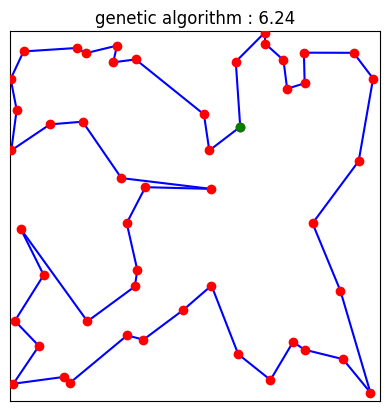

In [17]:
# choose the algorithm - we use standard genetic algorithm
algorithm = GA(
    pop_size=20,  # number of individuals in population
    sampling=PermutationRandomSampling(),  # how new individuals are generated - this ensure we actually get permutations
    mutation=InversionMutation(),  # mutation and crossover operators applicable to permutations
    crossover=OrderCrossover(),
    repair=StartFromZeroRepair(),  # our repair operator, maybe does not use here
    eliminate_duplicates=True  # whether to remove duplicate solutions from population
)

problem = TSP_problem(cities)  # create problem for our cities
termination = get_termination("n_eval", number_of_evaluations)  # set termination criterion, we use number of function evaluations

res = minimize(problem, algorithm, termination, seed=0)  # call minimize to solve the problem
best_solution_ga = res.X  # recover best solution
best_cost_ga = evaluate_solution(cities, best_solution_ga)
best_costs_ga = problem.best_costs

plot_solution(cities, best_solution_ga, None, title="genetic algorithm : {:.2f}".format(best_cost_ga))

Again, an overall better solution was found. It is often the case that the final solution is further improved by applying the local search. We do this in the following code segment, using our hill climbing implementation with a limited number of evaluations.

Evaluations 2045 / 4000


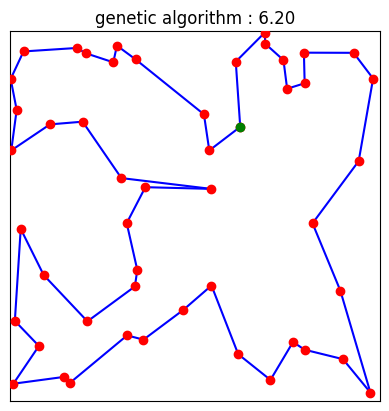

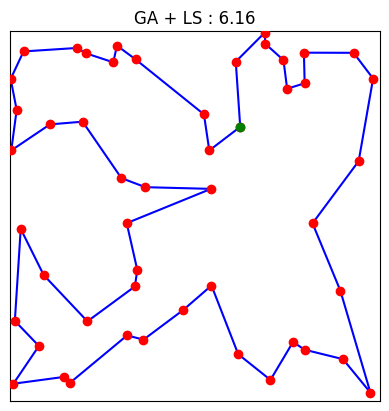

In [18]:
# try to improve solution using local search
best_solution_ga_ls = res.X.copy()
best_costs_ga_ls = problem.best_costs.copy()
best_solution_ga_ls, best_cost_ga_ls, new_costs, _ = hill_climbing(best_solution_ga_ls, cities, number_of_evaluations // 5)
best_costs_ga_ls += new_costs

# run GA again, this time for additional 4000 individuals to compensate for given limit to the LS
problem = TSP_problem(cities)  # create problem for our cities
termination = get_termination("n_eval", number_of_evaluations + 4000)  # set termination criterion, we use number of function evaluations
res = minimize(problem, algorithm, termination, seed=0)  # call minimize to solve the problem
best_solution_ga_extended = res.X  # recover best solution
best_cost_ga_extended = evaluate_solution(cities, best_solution_ga_extended)
best_costs_ga_extended = problem.best_costs

# Plot GA
plot_solution(cities, best_solution_ga_extended, None, title="genetic algorithm : {:.2f}".format(best_cost_ga_extended))

# Plot LS
plot_solution(cities, best_solution_ga_ls, None, title="GA + LS : {:.2f}".format(best_cost_ga_ls))

The solution improved once again, but just marginally. Now, we visualize all obtained solutions and compare them.

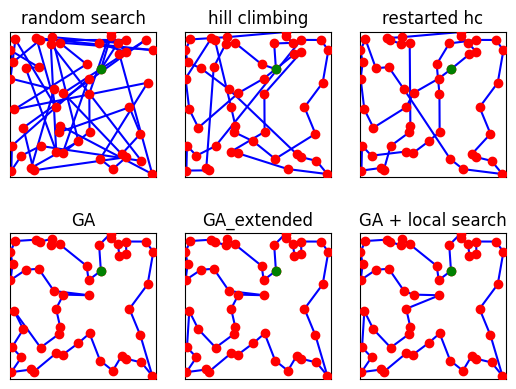

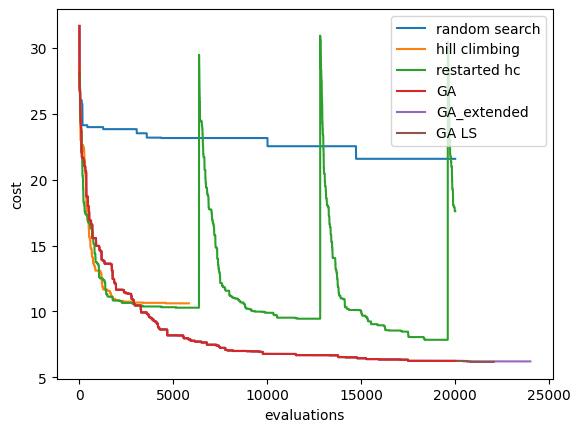

In [19]:
fig, axes = plt.subplots(2, 3)
plot_solution(cities, best_solution_random_search, axes[0,0], "random search")
plot_solution(cities, best_solution_hill_climbing, axes[0,1], "hill climbing")
plot_solution(cities, best_solution_restarted_hc, axes[0,2], "restarted hc")
plot_solution(cities, best_solution_ga, axes[1,0], "GA")
plot_solution(cities, best_solution_ga_extended, axes[1,1], "GA_extended")
plot_solution(cities, best_solution_ga_ls, axes[1,2], "GA + local search")
plt.show()

fig, ax = plt.subplots()
ax.plot(best_costs_random_search, label="random search")
ax.plot(best_costs_hill_climbing, label="hill climbing")
ax.plot(best_costs_restarted_hc, label="restarted hc")
ax.plot(best_costs_ga, label="GA")
ax.plot(best_costs_ga_extended, label="GA_extended",zorder=-1)
ax.plot(best_costs_ga_ls, label="GA LS", zorder=-1)
ax.set_xlabel("evaluations")
ax.set_ylabel("cost")
ax.legend()
plt.show()

The chart shows how the best solution changed with more and more function evaluations used (with the exception of restarted hill climbing, where we show each of the restarted runs instead). While it required quite some time, the genetic algorithm eventually outperformed the hill-climbing approaches and was even slightly improved by the local search in the end. Also, note, how inefficient is just randomly sampling permutations.

Finally, as an interesting point, study how the genetic algorithm performs with a population of just single individual.

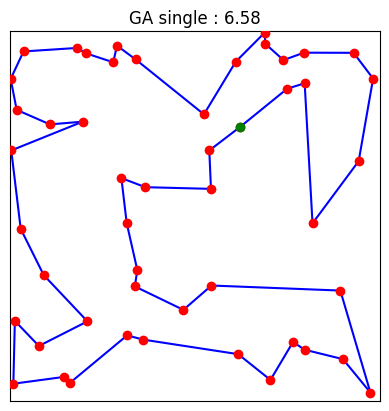

In [23]:
algorithm = GA(
    pop_size=1,
    sampling=PermutationRandomSampling(),
    mutation=InversionMutation(),
    crossover=OrderCrossover(),
    repair=StartFromZeroRepair(),
    eliminate_duplicates=True
)

problem = TSP_problem(cities)
termination = get_termination("n_eval", number_of_evaluations)

res = minimize(problem, algorithm, termination, seed=0)
best_solution_ga_single  = res.X
best_cost_ga_single = evaluate_solution(cities, best_solution_ga_single)
best_costs_ga_single = problem.best_costs

plot_solution(cities, best_solution_ga_single, None, title="GA single : {:.2f}".format(best_cost_ga_single))

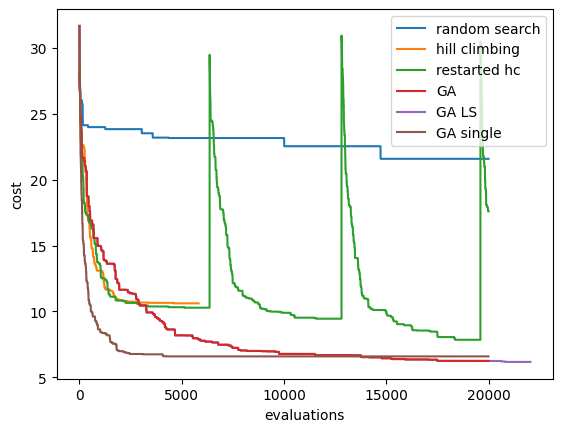

In [22]:
fig, ax = plt.subplots()
ax.plot(best_costs_random_search, label="random search")
ax.plot(best_costs_hill_climbing, label="hill climbing")
ax.plot(best_costs_restarted_hc, label="restarted hc")
ax.plot(best_costs_ga, label="GA")
ax.plot(best_costs_ga_ls, label="GA LS", zorder=-1)
ax.plot(best_costs_ga_single, label="GA single")
ax.set_xlabel("evaluations")
ax.set_ylabel("cost")
ax.legend()
plt.show()

Its performance is staggering, especially when we introduced the genetic algorithm as a **population**-based approach. How is it possible that the population of size 1 outperforms almost everything?

It just so happens that the mutation operator, which is essentially the only one that has any effect on how the optimization works in this case, is defined as follows:

```
1) select two indices in a permutation
2) reverse the subsequence defined by these indices
```
This corresponds to moves used in the 2-opt local search for TSP. Since the 2-opt and, more generally, [LKH](http://webhotel4.ruc.dk/~keld/research/LKH/) heuristics are considered to be one of the best solvers for the TSP (optimal solution for 109399 cities), there is not much we can do trying to compete with it. However, this is true for the well-known and thoroughly studied TSP. In many different domains, such effective local search moves may not exist, so metaheuristic guidance is necessary.


# Conclusion

We introduced a few concepts and examples of how to apply heuristic and metaheuristic algorithms to a well-known combinatorial problem - TSP.

Often when tackling an optimization problem, researchers will start with an ILP or other exact method since, with a mathematical model of the problem, it is easy to use general solvers to solve them. Then, when the solver's performance is insufficient or its computation time is prohibitive, the heuristic approaches start to be developed. Later, these heuristic approaches are guided with metaheuristics to obtain results worth reporting, with the ILP used as a baseline for comparisons.

We have already highlighted the main advantages of the heuristic methods. They are generally accessible (at least monetarily), we can easily exploit the specific features of the domain, and they can deliver a high-quality solution quickly. On the other hand, we lose the guarantees that exact methods offer - obtaining actual optimum, optimality gap reporting, etc. Finally, once we formulate the problem using ILP, we can just call the underlying solver.

Of course, there can be different ways how to formulate the problem, how to set the parameters of the solver, and how to choose the value of big-M; all do influence the performance of the solver. Nevertheless, the solver should behave reasonably well in almost every instance.

On the other hand, especially in the case of metaheuristics, using them to optimize a particular problem is an art rather than sound science. Selecting a suitable neighborhood, suitable metaheuristic, and even their hyper-parameters, such as the initial temperature of the simulated annealing, length of tabu list in tabu search, or mutation operator in the genetic algorithm, have a drastic effect on the results of the optimization.

In conclusion, both approaches and their possible combinations and hybridizations have their place in a portfolio of optimization methods, but the researcher should know the positives and negatives of them and what problems he may encounter once he decides what to use.

# Minimum Vertex Cover Example

If you have time, you may try to use the aforementioned metaheuristics to solve the minimum vertex cover we studied in one of the early tutorials.

Given graph $G = (V,E)$ described by edges $e \in E$, find a vertex set $A^*$, such that:

\begin{aligned}
A^* =  && \arg\min_{A \subseteq V} |A| && \\
\textrm{subject to} && u \in A ~\lor v \in A && ∀\left\{u,v\right\}\in E
\end{aligned}

We represent the solution as a binary vector of size $|V|$, where 1 means the vertex is a member of $A$.

In [25]:
# reimport so the Minimum Vertex Cover Example can be run independently
import random
import math
import matplotlib.pyplot as plt

# calculate euclidean distance between vertices (redefine)
# used to generate edges only between two close vertices
def vertex_distance(c1, c2):
    return math.sqrt((c1[0] - c2[0]) ** 2 + (c1[1] - c2[1]) ** 2)

def generate_graph(nm_vertices, edge_distance):  # generate graph and layout
    # Explicitly generate cities so the example is not reliable on prev code
    # Edge are generated between vertices which are at most edge_distance far
    # from each other
    vertices = [(random.random(), random.random()) for city in range(nm_vertices)]
    graph = []
    for i in range(nm_vertices):
        for j in range(i+1, nm_vertices):
            if vertex_distance(vertices[i], vertices[j]) <= edge_distance:
                graph.append((i,j))
    return vertices, graph

def evaluate_cover(graph, solution):  # evaluate vertex cover, return -1 if not cover
    for i, j in graph:
        if solution[i] + solution[j] == 0:
            return -1
    return sum(solution)

def plot_cover(vertices, graph, solution, ax=None, title=""):  # plot solution, members of cover shown in green
    other_axis = ax is not None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()

    for edge in graph:
        c1, c2 = vertices[edge[0]], vertices[edge[1]]
        ax.plot([c1[0], c2[0]], [c1[1], c2[1]], c="blue")
    ax.scatter([c[0] for c in vertices], [c[1] for c in vertices], c=["green" if solution[i] else "red" for i in range(len(vertices))], zorder=1e6,s=80)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    if not other_axis:
        plt.show()

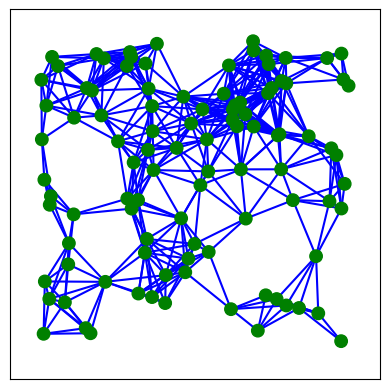

In [26]:
random.seed(5)  # generate instance
nm_vertices = 100
edge_distance = 0.2
vertices, graph = generate_graph(nm_vertices, edge_distance)

plot_cover(vertices, graph, [1 for i in range(nm_vertices)])

Either you can solve the problem using the genetic algorithm, whose skeleton we prepared below. In the TSP case, there were prepared operators to handle the fact only permutations are a feasible solution. This is not true now. We thus need to ensure that either only feasible binary vectors are considered (using a repair operator) or that the infeasible solutions are penalized so the algorithm can distinguish them.

Both of these approaches are common when constraints need to be handled in evolutionary algorithms.

In [27]:
import numpy as np
!pip install pymoo
import pymoo

from pymoo.algorithms.soo.nonconvex.ga import BGA
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.repair import Repair
from pymoo.operators.crossover.spx import SPX
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize

class MinVertexCoverProblem(ElementwiseProblem): # define a studied problem using Pymoo constructs
    def __init__(self, graph, nm_vertices):
        self.nm_vertices = nm_vertices
        self.graph = graph  # Contains edges of the graph

        super().__init__(n_var=nm_vertices, n_obj=1, vtype=int, xl=0, xu=1)  # initialize the parent Problem class with description of variables and objectives

    def _evaluate(self, x, out, *args, **kwargs):  # define how to evaluate the solution
        vertex_cost = np.sum(x)
        constraint_cost = 0

        # TODO implement constraint violation penalty
        # the algorithm should be attracted to feasible solutions just by the cost alone

        out["F"] = vertex_cost + constraint_cost
        self.cost = out["F"]  # Added for access

class RepairVertexCover(Repair):  # repair applied to individuals
    def _do(self, problem, X, **kwargs):
        for i in range(X.shape[0]):
            # TODO implement Vertex cover repair
            # X is numpy array of size (n_individuals, nv_vertices)
            # problem variable is a reference to problem object above
            # your repair operator should take even infeasible solution and make it feasible
            # that is, if an edge is not covered, you probably should include one or both of
            # its end points in the cover
            pass
        return X

Defaulting to user installation because normal site-packages is not writeable


Notice that we changed the bounds of the variables in the Problem class. Also, we need to select suitable operators - the previous tailored to optimizing permutations would not be helpful in this case.

The binary random sampling operator creates the initial population of binary vectors. A single-point crossover takes two individuals, randomly splits their chromosomes at the same point, and creates new individuals by gluing together the first part of one parent and the second part of the second parent. BitFlip mutation can then change the value of a gene from 0 to 1 and vice versa.

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       50 |  5.082000E+01 |  4.000000E+01
     2 |      100 |  4.598000E+01 |  4.000000E+01
     3 |      150 |  4.274000E+01 |  3.800000E+01
     4 |      200 |  4.022000E+01 |  3.600000E+01
     5 |      250 |  3.844000E+01 |  3.500000E+01
     6 |      300 |  3.666000E+01 |  3.200000E+01
     7 |      350 |  3.452000E+01 |  2.900000E+01
     8 |      400 |  3.266000E+01 |  2.800000E+01
     9 |      450 |  3.062000E+01 |  2.700000E+01
    10 |      500 |  2.910000E+01 |  2.600000E+01
    11 |      550 |  2.752000E+01 |  2.200000E+01
    12 |      600 |  2.564000E+01 |  2.100000E+01
    13 |      650 |  2.340000E+01 |  1.900000E+01
    14 |      700 |  2.174000E+01 |  1.700000E+01
    15 |      750 |  2.032000E+01 |  1.600000E+01
    16 |      800 |  1.904000E+01 |  1.600000E+01
    17 |      850 |  1.758000E+01 |  1.500000E+01
    18 |      900 |  1.634000E+01 |  1.400000E+01
    19 |      950 |  1.548000E+01 |  1.300000E+01


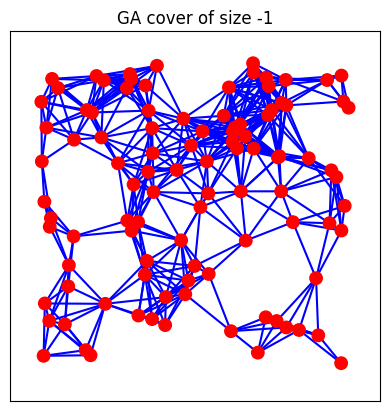

In [28]:
problem = MinVertexCoverProblem(graph, nm_vertices)

termination = get_termination("n_eval", 2000)

algorithm = BGA(
    pop_size=50,
    sampling=BinaryRandomSampling(),  # binary random sampling
    crossover=SPX(),  # single point crossover
    mutation=BitflipMutation(),  # bitflip mutation
    repair=RepairVertexCover(),  # our repair operator
    eliminate_duplicates=True
)


res = minimize(problem,
               algorithm,
               termination=termination,
               seed=0,
               verbose=True)

solution = res.X
cover_size = evaluate_cover(graph, solution)

plot_cover(vertices, graph, solution, title=f"GA cover of size {cover_size}")

Alternatively, implement a local search-based approach here. Note that there is a 2-approximation algorithm for finding a vertex cover. If you do not want to do anything complicated, start by using the idea of hill-climbing.

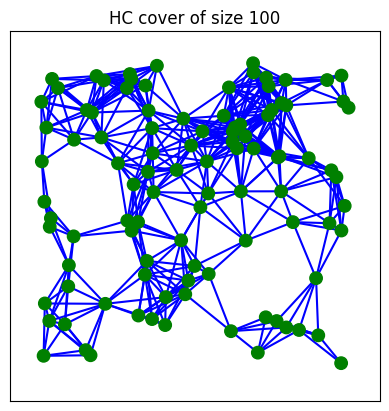

In [29]:
np.random.seed(0)
initial_solution = [1 for i in range(nm_vertices)]
number_of_evaluations = 2000

# TODO implement local search approach

solution = initial_solution
cover_size = evaluate_cover(graph, solution)
plot_cover(vertices, graph, solution, title=f"HC cover of size {cover_size}")

The minimum vertex cover of this size is solvable by Gurobi for the given size so that we can compare our heuristic results with an optimal solution.

Defaulting to user installation because normal site-packages is not writeable
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 529 rows, 100 columns and 1058 nonzeros
Model fingerprint: 0x6f174f88
Variable types: 0 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 85.0000000
Presolve removed 529 rows and 100 columns
Presolve time: 0.02s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 80 85 

Optimal solution found (tolerance 1.00e-04)
Best objective

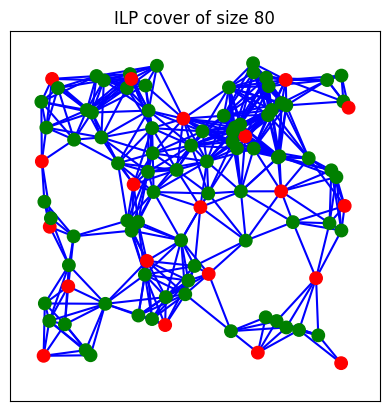

In [30]:
# reimport so the Minimum Vertex Cover Example can be run independently
!pip install gurobipy
import gurobipy as g

# Build and optimize model
m = g.Model()
cover = m.addVars(nm_vertices, vtype=g.GRB.BINARY)
for i, j in graph:
    m.addConstr(cover[i] + cover[j] >= 1)
m.setObjective(cover.sum(), sense=g.GRB.MINIMIZE)
m.optimize()

solution = [1 if round(cover[i].x) > 0.5 else 0 for i in range(nm_vertices)]
cover_size = evaluate_cover(graph, solution)
plot_cover(vertices, graph, solution,title=f"ILP cover of size {cover_size}")